In [20]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from ast import literal_eval
from tqdm import tqdm

from nltk.tokenize import sent_tokenize

In [21]:
DATA_PATH = os.path.join(
    "..", "..", "..", "..", "data", "frameworks_data", "per_proj_data"
)

def flatten(t):
    """
    flatten a list of lists.
    """
    return [item for sublist in t for item in sublist]


turkey_df = (
    pd.read_csv(os.path.join(DATA_PATH, "2021_ifrc_turkey_v0.1.1.csv"))
    .drop(
        columns=[
            "entry_type",
            "created_by_id",
            "lead_id",
            "modified_by_id",
            "project_id",
            "title",
            "id_entry",
            "response type",
            "analysis_framework_id",
            "additional_text",
            "modified_at",
        ]
    )
    .drop_duplicates()
    .rename(columns={"id": "entry_id"})
    .dropna()
).rename(
    columns={
        "1dpillars": "pillars_1d",
        "1dsubpillars": "subpillars_1d",
        "2dpillars": "pillars_2d",
        "2dsubpillars": "subpillars_2d",
    }
)

turkey_df["created_at"] = pd.to_datetime(turkey_df.created_at).apply(lambda x: x.date)
geo_mapping_df = pd.read_csv(os.path.join(DATA_PATH, "geoarea_v0.1.csv")).rename(
    columns={"id": "area_id"}
)
turkey_df["geolocation"] = turkey_df["geolocation"].apply(
    lambda x: list(set(literal_eval(x)))
)


In [22]:
turkey_proj_locations = geo_mapping_df[geo_mapping_df['area_id'].isin(list(set(flatten(turkey_df['geolocation']))))]

geo_mapper_dict = {x['area_id']: x['title'] for _, x in turkey_proj_locations.iterrows()}
mappable_ids = list(geo_mapper_dict.keys())

In [23]:
len(mappable_ids)

393

In [24]:
turkey_df['geolocation'] = turkey_df['geolocation'].apply(
    lambda x: [geo_mapper_dict[item] for item in x if item in mappable_ids]
)
turkey_df.head(2)

,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
0,574620,2022-05-05,The Afghan diaspora in Turkey live in fear: xe...,[],[],[],[],['Displacement'],['Displacement->Social Cohesion'],[TURKEY],[],[],"['Affected', 'Displaced', 'Refugees (internati...",[],[],False
1,574621,2022-05-05,Turkey has been hosting one of the world's lar...,[],[],[],[],['Displacement'],['Displacement->Social Cohesion'],[TURKEY],[],[],"['Affected', 'Migrants']",[],[],False


In [6]:
turkey_df.created_at.value_counts()

2022-03-25    309
2020-04-14    272
2022-04-12    216
2022-02-02    202
2022-05-25    195
             ... 
2021-02-10      2
2019-08-28      2
2020-09-09      2
2020-11-25      1
2020-05-01      1
Name: created_at, Length: 450, dtype: int64

In [7]:
from datetime import date, timedelta

today = date.today()

def allsundays(year):
    days_list = []
    d = date(year, 4, 1)                    # January 1st
    d += timedelta(days = 6 - d.weekday())  # First Sunday
    while d < today:
        d += timedelta(days = 7)
        days_list.append(d)
    return days_list[:-1]

days = allsundays(2022)

In [8]:
def custom_eval(x):
    if str(x)=='nan':
        return []
    if str(x)=='[None]':
        return []
    if type(x)==list:
        return x
    else:
        return literal_eval(x)

def get_props(column):
    clean_col = flatten([list(set(item)) for item in column.apply(custom_eval)])
    props = {name: 100 * counts / len(column) for name, counts in dict(Counter(clean_col)).items()}
    return props

sectors = []
subpillars_1d = []
subpillars_2d = []
demographic_groups = []	
affected_groups = []
geo_locations = []

for i in tqdm(range (len(days) - 1)):
    start_date = days[i]
    end_date = days[i + 1]
    one_week_df = turkey_df[turkey_df.created_at.apply(lambda x: x>=start_date and x<end_date)]

    sectors.append(get_props(one_week_df.sectors))
    subpillars_1d.append(get_props(one_week_df['pillars_1d']))
    subpillars_2d.append(get_props(one_week_df['pillars_2d']))
    demographic_groups.append(get_props(one_week_df['demographic groups']))
    affected_groups.append(get_props(one_week_df['affected groups']))
    geo_locations.append(get_props(one_week_df['geolocation']))

df_dates = [f'{days[i]}->{days[i+1]}'.replace('2022-', '') for i in range (len(days) - 1)]

100%|██████████| 15/15 [00:01<00:00, 11.89it/s]


In [9]:
df_dates

['04-10->04-17',
 '04-17->04-24',
 '04-24->05-01',
 '05-01->05-08',
 '05-08->05-15',
 '05-15->05-22',
 '05-22->05-29',
 '05-29->06-05',
 '06-05->06-12',
 '06-12->06-19',
 '06-19->06-26',
 '06-26->07-03',
 '07-03->07-10',
 '07-10->07-17',
 '07-17->07-24']

In [10]:
df_sectors = pd.DataFrame(sectors).fillna(0)
df_sectors['dates'] = df_dates
#df_sectors

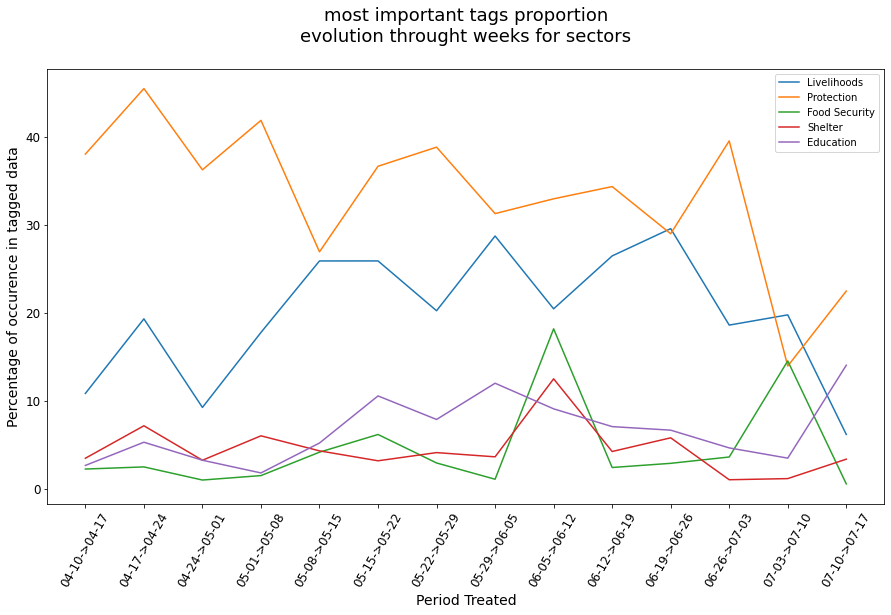

In [67]:
plt.figure(figsize=(15, 8))
for col in ['Livelihoods', 'Protection', 'Food Security', 'Shelter', 'Education']:
    sns.lineplot(data=df_sectors, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for sectors\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/sectors.png', bbox_inches='tight', facecolor='white')

In [33]:
df_subpillars_1d = pd.DataFrame(subpillars_1d).fillna(0)
df_subpillars_1d['dates'] = df_dates
#df_subpillars_1d

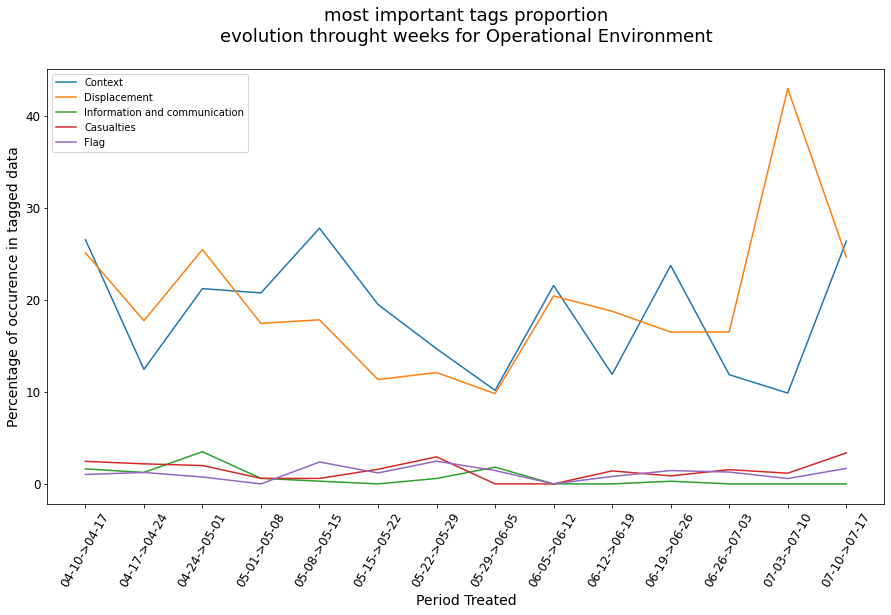

In [68]:
plt.figure(figsize=(15, 8))
for col in ['Context', 'Displacement', 'Information and communication', 'Casualties', 'Flag']:
    sns.lineplot(data=df_subpillars_1d, x='dates', y=col, label=col)
    plt.legend()
    
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for Operational Environment\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/pillars_1d.png', bbox_inches='tight', facecolor='white')

In [32]:
df_subpillars_2d = pd.DataFrame(subpillars_2d).fillna(0)
df_subpillars_2d['dates'] = df_dates
#df_subpillars_2d

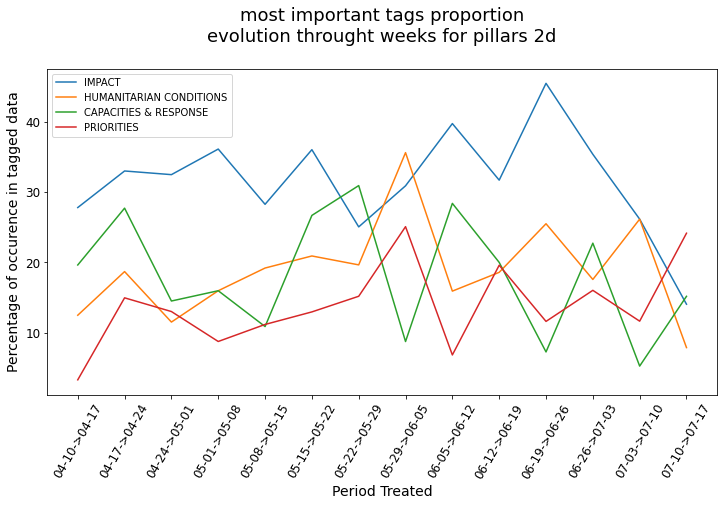

In [69]:
plt.figure(figsize=(12, 6))
for col in ['IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES']:
    sns.lineplot(data=df_subpillars_2d, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for pillars 2d\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/pillars_2d.png', bbox_inches='tight', facecolor='white')

In [25]:
"""df_demographic_groups = pd.DataFrame(demographic_groups).fillna(0)
df_demographic_groups['dates'] = df_dates
df_demographic_groups"""

"df_demographic_groups = pd.DataFrame(demographic_groups).fillna(0)\ndf_demographic_groups['dates'] = df_dates\ndf_demographic_groups"

In [35]:
df_affected_groups = pd.DataFrame(affected_groups).fillna(0)
df_affected_groups['dates'] = df_dates
#df_affected_groups

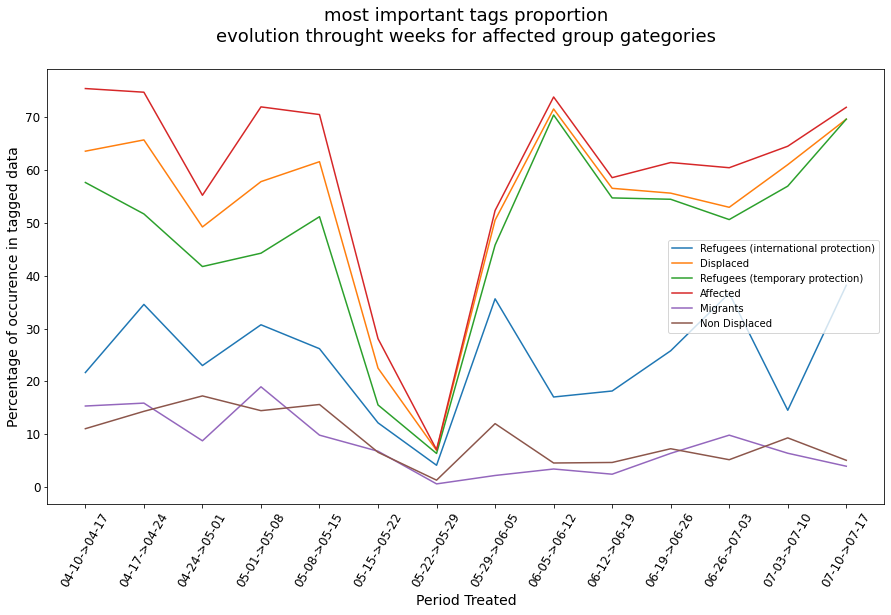

In [70]:
plt.figure(figsize=(15, 8))
for col in [
    "Refugees (international protection)",
    "Displaced",
    "Refugees (temporary protection)",
    "Affected",
    "Migrants",
    "Non Displaced",
]:
    sns.lineplot(data=df_affected_groups, x="dates", y=col, label=col)
    plt.legend()
    
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for affected group gategories\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/affected_groups_1.png', bbox_inches='tight', facecolor='white')

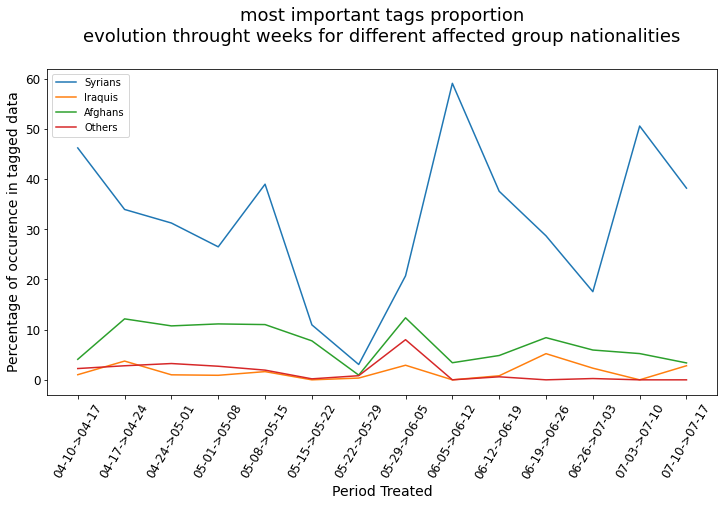

In [71]:
from numpy import size


plt.figure(figsize=(12, 6))
for col in [
    'Syrians', 'Iraquis', 'Afghans', 'Others'
]:
    sns.lineplot(data=df_affected_groups, x="dates", y=col, label=col)
    plt.legend()
plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for different affected group nationalities\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/affected_groups_2.png', bbox_inches='tight', facecolor='white')

In [30]:
df_geo_area = pd.DataFrame(geo_locations).fillna(0)
df_geo_area['dates'] = df_dates
most_important_places = df_geo_area.columns[np.argsort(df_geo_area.mean())[-5:-1]]
most_important_places

Index(['IZMIR', 'GAZIANTEP', 'ANKARA', 'ISTANBUL'], dtype='object')

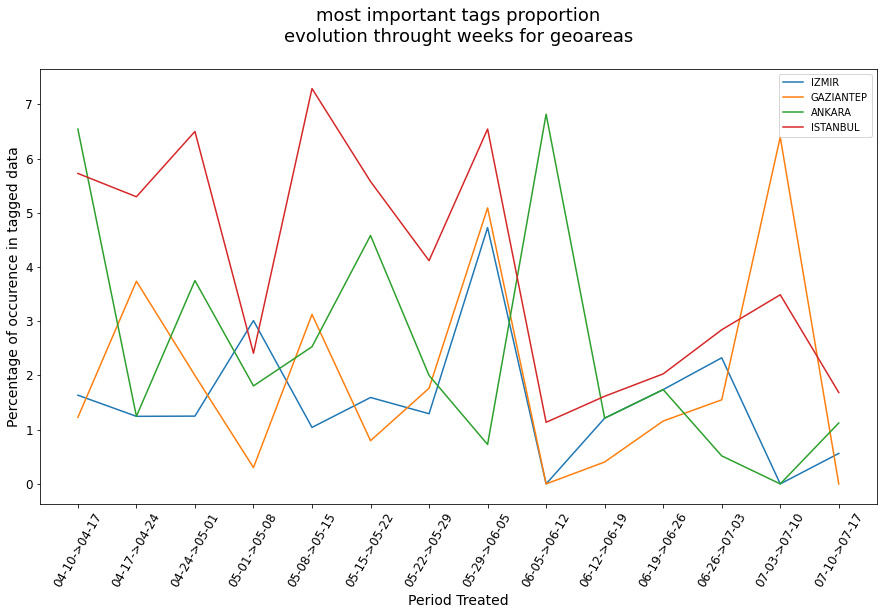

In [72]:
plt.figure(figsize=(15, 8))
for col in most_important_places:
    sns.lineplot(data=df_geo_area, x='dates', y=col, label=col)
    plt.legend()

plt.xticks(rotation=60, size=12)
plt.yticks(size=12)

plt.title('most important tags proportion\nevolution throught weeks for geoareas\n', size=18)
plt.ylabel("Percentage of occurence in tagged data", size=14)
plt.xlabel("Period Treated" ,size=14)
plt.savefig('Turkey_first_analysis_data/vizu/geo_locs.png', bbox_inches='tight', facecolor='white')

In [39]:
sorted(list(set(flatten(turkey_df['demographic groups']))))

['Adult (18 to 59 years old)',
 'Adult Female (18 to 59 years old)',
 'Adult Male (18 to 59 years old)',
 'Children (5 to 11 years old)',
 'Children (< 18 years)',
 'Children Female  <18 years old',
 'Children Female (5 to 11 years old)',
 'Children Male (5 to 11 years old)',
 'Children Male < 18 years old',
 'Female Older Persons (60+ years old)',
 'Infants/Toddlers (<5 years old)',
 'Male Older Persons (60+ years old)',
 'Older Persons (60+ years old)',
 'Youth (12 to 17 years old)',
 'Youth Female (12 to 17 years old)',
 'Youth Male (12 to 17 years old)']

In [40]:
demographic_groups_age_mapper = {
 'Adult (18 to 59 years old)': 'age->Adult (18 to 59 years old)',
 'Adult Female (18 to 59 years old)': 'age->Adult (18 to 59 years old)',
 'Adult Male (18 to 59 years old)': 'age->Adult (18 to 59 years old)',
 'Children (5 to 11 years old)': 'age->Children (5 to 11 years old)',
 'Children (< 18 years)': 'age->Children (5 to 17 years old)',
 'Children Female  <18 years old': 'age->Children (5 to 17 years old)',
 'Children Female (5 to 11 years old)': 'age->Children (5 to 17 years old)',
 'Children Male (5 to 11 years old)': 'age->Children (5 to 17 years old)',
 'Children Male < 18 years old': 'age->Children (5 to 17 years old)',
 'Female Older Persons (60+ years old)': 'age->Older Persons (60+ years old)',
 'Infants/Toddlers (<5 years old)': 'age->Infants/Toddlers (<5 years old)',
 'Male Older Persons (60+ years old)': 'age->Older Persons (60+ years old)',
 'Older Persons (60+ years old)': 'age->Older Persons (60+ years old)',
 'Youth (12 to 17 years old)': 'age->Children (5 to 17 years old)',
 'Youth Female (12 to 17 years old)': 'age->Children (5 to 17 years old)',
 'Youth Male (12 to 17 years old)': 'age->Children (5 to 17 years old)'
}

demographic_groups_gender_mapper = {
 'Adult Female (18 to 59 years old)': 'gender->Female',
 'Adult Male (18 to 59 years old)': 'gender->Male',
 'Children Female  <18 years old': 'gender->Female',
 'Children Female (5 to 11 years old)': 'gender->Female',
 'Children Male (5 to 11 years old)': 'gender->Male',
 'Children Male < 18 years old': 'gender->Male',
 'Male Older Persons (60+ years old)': 'gender->Male',
 'Youth Female (12 to 17 years old)': 'gender->Female',
 'Youth Male (12 to 17 years old)': 'gender->Male'
}

mappable_groups = list(demographic_groups_gender_mapper.keys())

turkey_df['demographic groups'] = turkey_df['demographic groups'].apply(custom_eval)
turkey_df['demographic groups'] = turkey_df['demographic groups'].apply(
    lambda x: [demographic_groups_age_mapper[item] for item in x] + [demographic_groups_gender_mapper[item] for item in x if item in mappable_groups]
)

 ## NLP BASED ANALYSIS

In [25]:
turkey_df['excerpt'] = turkey_df['excerpt'].apply(sent_tokenize)
turkey_df = turkey_df.explode('excerpt')

In [26]:
turkey_df["subsectors"] = turkey_df["subsectors"].apply(custom_eval)
turkey_df["sectors"] = turkey_df["sectors"].apply(custom_eval)

turkey_df["subsectors"] = turkey_df.apply(
    lambda x: x["subsectors"]
    if len(x["subsectors"]) > 0
    else list(set([f"{item}->General Overview" for item in x["sectors"] if item!='Cross'])),
    axis=1,
)


In [27]:
#june_df, july_df_first_week, july_df_second_week

In [28]:
june = turkey_df[turkey_df.created_at.apply(lambda x: x.month==6 and x.year==2022)]
print(june.shape)
june.head(2)

(3352, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
47,597788,2022-06-27,"7 parties and formations, including the People...",[Cross],[],['PRIORITIES'],['PRIORITIES->Priority Interventions (Staff)'],['Context'],['Context->Politics'],[TURKEY],[],[],"['Affected', 'Displaced', 'Refugees (temporary...",[],[],False
47,597788,2022-06-27,"The Workers' Party of Turkey (TİP), the Labour...",[Cross],[],['PRIORITIES'],['PRIORITIES->Priority Interventions (Staff)'],['Context'],['Context->Politics'],[TURKEY],[],[],"['Affected', 'Displaced', 'Refugees (temporary...",[],[],False


In [29]:
july_df_first_week = turkey_df[turkey_df.created_at.apply(lambda x: x.day<10 and x.month==7 and x.year==2022)]
print(july_df_first_week.shape)
july_df_first_week.head(2)

(432, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
904,602544,2022-07-05,Turkish forces held 40 irregular migrants in e...,[Protection],[Protection->General Overview],['IMPACT'],['IMPACT->Impact on People'],"['Casualties', 'Displacement']","['Casualties->Injured', 'Displacement->Type/Nu...","[SARAY, VAN, TURKEY]",[],[],"['Affected', 'Migrants', 'Irregular']",[],[],True
904,602544,2022-07-05,Gendarmerie officers at a checkpoint attempted...,[Protection],[Protection->General Overview],['IMPACT'],['IMPACT->Impact on People'],"['Casualties', 'Displacement']","['Casualties->Injured', 'Displacement->Type/Nu...","[SARAY, VAN, TURKEY]",[],[],"['Affected', 'Migrants', 'Irregular']",[],[],True


In [30]:
july_df_second_week = turkey_df[turkey_df.created_at.apply(lambda x: x.day>=10 and x.month==7 and x.year==2022)]
print(july_df_second_week.shape)
july_df_second_week.head(2)

(755, 16)


,entry_id,created_at,excerpt,sectors,subsectors,pillars_2d,subpillars_2d,pillars_1d,subpillars_1d,geolocation,specific needs groups,demographic groups,affected groups,reliability,severity,subsectors_negative
10616,605271,2022-07-11,A communiqué by the Interior Ministry further ...,[Protection],[Protection->General Overview],['IMPACT'],['IMPACT->Impact on People'],[],[],[TURKEY],[],[],"['Affected', 'Migrants']",[],[],True
10639,605282,2022-07-11,"According to authorities, officers had tried t...","[Protection, Protection]",[Protection->Justice and Rule of Law],"['IMPACT', 'IMPACT']","['IMPACT->Impact on People', 'IMPACT->Impact o...",[],[],[TURKEY],[],[],[],[],[],False


* per sector -> subsector: Livelihoods, Protection, Shelter, Education

* per pillars_1d -> subpillars_1d: Context, Displacement

* per pillars_2d -> subpillars_2d: 'IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES'

* per affected group -> Reguees tempoorary/international, syrian, afghans

* specific geolocations -> Not the most common one

In [132]:
from generate_summary import preprocesss_row, get_summary_one_part, get_severity_score, get_reliability_score, get_numbers_score

In [140]:
july_df_first_week.to_csv('Turkey_fist_analysis/july_df_first_week.csv', index=None)
july_df_second_week.to_csv('Turkey_fist_analysis/july_df_second_week.csv', index=None)
june.to_csv('Turkey_fist_analysis/june.csv', index=None)

In [ ]:
#assertion not to run this cell on local
assert(1==2)

# this cell is run on colab
import json

data = {'july_second_week': july_df_second_week, 'july_first_week': july_df_first_week}

columns_treated_items = {
    'affected groups': ['Refugees (international protection)', 'Refugees (temporary protection)', 'Syrians', 'Iraquis'],
    #'geolocation': ['IZMIR', 'GAZIANTEP', 'ANKARA', 'ISTANBUL'],
    'sectors': ['Protection', 'Livelihoods', 'Shelter', 'Education'],
    'pillars_1d': ['Context', 'Displacement'],
    'pillars_2d': ['IMPACT', 'HUMANITARIAN CONDITIONS', 'CAPACITIES & RESPONSE', 'PRIORITIES'],
}

reports = {}

for report_title, report_df in data.items():
    report_one_df = {}

    # Columns used later for classification
    report_df["severity_scores"] = report_df["severity"].apply(get_severity_score)
    report_df["reliability_scores"] = report_df["reliability"].apply(get_reliability_score)
    report_df['subpillars'] = report_df.apply(
        lambda x: list(set(custom_eval(x['subpillars_1d']) + custom_eval(x['subpillars_2d']))), axis=1
    )
    report_df["present_numbers_score"] = report_df["subpillars"].apply(get_numbers_score)

    for col_name, kept_items in columns_treated_items.items():

        print(f'begin {col_name}')

        report_df[col_name] = report_df[col_name].apply(
            lambda x: list(set([item for item in custom_eval(x) if item in kept_items]))
        )

        if col_name != 'affected groups':
            returns_one_pillar = {}
            for one_pillar in kept_items:
                report_df[one_pillar] = report_df[col_name].apply(
                    lambda x: list(set([item for item in custom_eval(x) if item in one_pillar]))
                )
                
                report_df[one_pillar] = report_df[one_pillar].apply(
                    lambda x: preprocesss_row(x, 1)
                )

                returns_one_pillar[one_pillar] = get_summary_one_part(
                    report_df, one_pillar, True
                )

            report_one_df[col_name] = returns_one_pillar

        else:
            report_df[col_name] = report_df[col_name].apply(
                lambda x: list(set([item for item in custom_eval(x) if item in col_name]))
            )
            
            report_df[col_name] = report_df[col_name].apply(
                lambda x: preprocesss_row(x, 1)
            )

            report_one_df[col_name] = get_summary_one_part(
                report_df, col_name, True
            )

    reports[report_title] = report_one_df

with open(f"Turkey_first_analysis_data/full_report.json", "w") as fp:
    json.dump(reports, fp)

## Generate report

In [1]:
from ast import literal_eval
import pandas as pd

In [2]:

from utils import update_outputs_list, omit_punctuation, order_dict

In [6]:
with open("Turkey_first_analysis_data/full_report_v3.json") as f:
    generated_data = f.read()

generated_data = literal_eval(generated_data)

In [7]:
generated_data = {
    period_name: {
        subsection_name: generated_data[period_name][subsection_name]
        for subsection_name in ["subsectors", "subpillars_2d", "subpillars_1d", "affected groups"]
    }
    for period_name in ["july_first_week", "july_second_week"]
}


In [8]:
final_report = ""
final_raw_outputs = ""

used_entries_df = pd.DataFrame()
for one_period_name, generated_data_one_period in generated_data.items():
    final_report, final_raw_outputs = update_outputs_list(
        final_report, final_raw_outputs, str(r"\newpage")
    )

    final_report, final_raw_outputs = update_outputs_list(
        final_report, final_raw_outputs, str("\n \section{" + one_period_name + "}\n")
    )

    one_period_df = pd.DataFrame()

    for (
        subsection_name,
        generated_data_one_subsection,
    ) in generated_data_one_period.items():
        final_report, final_raw_outputs = update_outputs_list(
            final_report,
            final_raw_outputs,
            str("\subsection{" + subsection_name + "}\n"),
        )

        for tag, generated_entries_one_tag in order_dict(
            generated_data_one_subsection
        ).items():

            final_report, final_raw_outputs = update_outputs_list(
                final_report,
                final_raw_outputs,
                str("\paragraph{" + omit_punctuation(tag) + "}\n"),
            )

            try:
                clean_generated_entries_one_tag = literal_eval(
                    generated_entries_one_tag
                )
            except Exception as e:
                clean_generated_entries_one_tag = generated_entries_one_tag
                
            final_report, final_raw_outputs = update_outputs_list(
                final_report, final_raw_outputs, clean_generated_entries_one_tag
            )

            #paragraph_df = update_df(generated_entries_one_tag)
            #paragraph_df["paragraph"] = f"{subsection_name}->{tag}"
            #one_period_df = one_period_df.append(paragraph_df)

            # final_str += clean_characters(v)
            final_report, final_raw_outputs = update_outputs_list(
                final_report, final_raw_outputs, "\n \n"
            )
    one_period_df["period"] = one_period_name

    used_entries_df = used_entries_df.append(one_period_df)

final_report = (
    final_report.replace("_", " ")
    .replace("june", "June")
    .replace("july", "July")
    .replace("subpillars 1d", "Operational Environment")
    .replace("subpillars 2d", "2D Pillars")
    .replace("subsectors", "Subsectors")
    .replace("affected groups", "Affected Groups")
)


In [9]:
print(final_report)

\newpage
 \section{July first week}
\subsection{Subsectors}
\paragraph{Protection}
 50,531 vulnerable Syrians under Temporary Protection (SuTP) and Humanitarian residence status holders reside in Temporary Accommodation Centers (camps) located in southeast of Türkiye. Syrian businessmen working in textiles say it has become more challenging in recent months to obtain work permits or to ease mobility restrictions for Syrian nationals.
 
\paragraph{Education}
 Ruba started working for a private school in 2014 and was quickly promoted to principal of the kindergarten section. After several years, Turkish authorities changed the regulation for Syrian schools, forcing the school to close. Ruba and two partners decided to open their own school–Yeni Dünya (New World) Education Center.
 
\subsection{2D Pillars}
\paragraph{IMPACT}
 Syrian businessmen working in textiles say it has become more challenging in recent months to obtain work permits or to ease mobility restrictions for Syrian nationa